# Bending Color Space with curves

Similar to the channel mixing, where we updated values from the source image with a new value as a function of all of the available colors at a pixel, bending color space also updates the value of a pixel in the destination image.  In this case, the output pixel value is only a function of the input pixel value, but the values are mapped using a curve.

These mapping curves are defined as:

$$ b_{output} = f_b( b_{input} ) $$

$$ g_{output} = f_g( g_{input} ) $$

$$ r_{output} = f_r( r_{input} ) $$


These mapping curves are specified by a set of control points rather than directly computing the transformation for each point.  Here we use the `scipy.interpolate.interp1d()` interpolation function to convert the control points into a smooth transformation curve.

In [1]:
%matplotlib inline

import cv2
import scipy.interpolate
import numpy as np
from matplotlib import pyplot as plt

---

We can define a generator function to produce functions that interpolate curves according to the number of control points that are available.  If there are fewer than 3 points, no interpolation is done, and no function is returned.  With exactly 3 points, `linear` interpolation is performed (rather than `quadratic`), and for more than 3 control points, we use `cubic` interpolation.

Here we are providing a simplified interface to the interpolation function generator that determines the style of interpolation as well as allowing for extrapolation of points as well.

In [2]:
def createCurve(points):
    """ create a function that transforms its input using a curve interpolated from control points
    
    This provides a simple interface to the scipy.interpolate.interp1d() function that selects
    linear interpolation for exactly 3 points, cubic interpolation for more than 3 points, and returns None
    for fewer than 3 points.  The returned function is enabled to perform extrapolation as well as
    interpolation.
    """
    if points is None:
        return None
    nPoints = len(points)
    if nPoints < 2:
        return None
    x, y = zip(*points)
    if nPoints < 4:
        kind = 'linear'
    else:
        kind = 'cubic'
    
    return scipy.interpolate.interp1d(x, y, kind, bounds_error=False)

To check the curve function generator, we can look at some of the results.  First lets look at a curve generated using only 3 control points.  This should return a mapping function that produces linear segments between the endpoints and the center point.

The plot shows the transformation of values in the interval `[0,255]` which corresponds to the pixel values we will be processing.  The blue curve shows an identity transformation - no change in value -while the orange curve shows the transformation produced from the interpolated control points.  We can see that the interpolation curve is composed of linear sections as we expected.

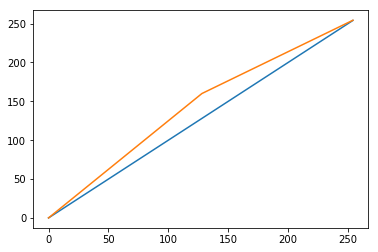

In [3]:
curve = createCurve([(0,0),(128,160),(255,255)])

x = np.arange(0,255,1)
y = curve(x)

plt.plot(x,x,'-',x,y,'-')
plt.show()

Looking at a curve with 5 control points should produce an interpolated cubic curve.  We can see that this is indeed the case in the plot below.

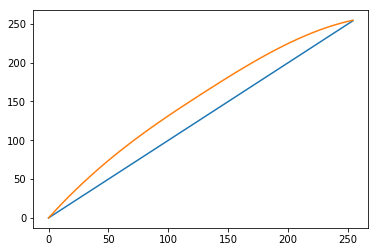

In [4]:
curve = createCurve([(0,0),(80,110),(128,160),(170,200),(255,255)])

x = np.arange(0,255,1)
y = curve(x)

plt.plot(x,x,'-',x,y,'-')
plt.show()

---

### Utilities used in filter composition

Below are some utility functions defined for use in our filter definitions.  These include functions that allow us to store and lookup transformations from a cache so that they become read operations from memory rather than requiring a function to compute a value each time.  This is especially useful if the three color channels use the same control points and can use the same lookup values.

In addition, a composite function generator is included that simplifies chaining function calls, and a conversion from higher dimension tensors to a single dimension view.  Conversion to a single dimension view is useful for cases where we are going to apply the same transformation to all pixels.  This allows a single call to process all colors of an image rather than making a separate call for each color channel.  Use of a view allows us to perform this processing without copying the data in order to rearrange it.

- createCache: creates a cached set of values.
- applyCache: looks up a transformation value from a cache.
- createComposite: creates a composite function that returns the result of calling a chain of functions.
- flatView: converts multiple dimension tensors into a flat vector of values.

In [5]:
def createCache(f,l=256):
    """ create a cache of transformation values
    
    Generates a lookup table for integer values between 0 and the specified limit value.
    Values outside this range are not allowed and the table values are clamped to 0 and the
    limit if the transformation would produce any extreme values.
    """
    if f is None:
        return None
    cache = np.empty(l)
    for i in range(l):
        f_i = f(i)
        cache[i] = min(max(0,f_i),l-1)
    return cache

In [6]:
def applyCache(cache,src,dst):
    """ transform values from the source vector to the destination vector
    
    Uses the source vector values as indices into the cache and returns the cached
    values found.
    """
    if cache is None:
        return
    dst[:] = cache[src]

In [7]:
def createComposite(f0,f1):
    """ create a composite function from two other functions
    
    Returns a function that calls the two provided functions in sequence.  If either
    function is not provided, the provided function will be called.
    """
    if f0 is None:
        return f1
    if f1 is None:
        return f0
    return lambda x: f0(f1(x))

In [8]:
def flatView(array):
    """ returns a vector view of an array
    """
    view = array.view()
    view.shape = array.size
    return view

---

We can now define some filter classes that will allow us to filter grayscale and color images.  We do this by defining a filter function class that exposes an `appy()` method that can be used to apply the filter function to data.  A curve filter class is then defined that creates one or more filter function objects using curves generated from the supplied control points.

The `VCurveFilter` class can convert both grayscale and color images by processing each pixel channel (value or bgr channels) using the same curve.

The `BGRCurveFilter` allows definition of transformation curves for each of the color channels as well as definition of an overall value curve that will be applied to all of the color channels.

In [9]:
class VFuncFilter(object):
    """ value function filter to cache and convert a single transformation of image pixel values
    
    Creates a value transformation cache and uses it to convert image pixel values.  This
    transformation will be applied to the single value channel of a grayscale image or to
    each color channel of a BGR image.
    """
    def __init__(self, f = None, dtype = np.uint8):
        """ create a cache for transformations of all integer values of the datatype
        """
        l = np.iinfo(dtype).max + 1
        self._cache = createCache(f,l)
        
    def apply(self, src, dst):
        """ transform a source image using the cached mappings
        """
        flatSrc = flatView(src)
        flatDst = flatView(dst)
        applyCache(self._cache,flatSrc,flatDst)

In [10]:
class VCurveFilter(VFuncFilter):
    """ create a filter using control points to define the curves
    """
    def __init__(self,points,dtype = np.uint8):
        """ create the interpolation filter curve using the defined control points
        """
        VFuncFilter.__init__(self, createCurve(points),dtype)

In [11]:
class BGRFuncFilter(object):
    """ function filter to cache and convert pixel values of color images
    
    Creates a transformation for each color channel and combines that with a transformation
    for the value channel and generates a cache of the transformations.  A composite
    transformation is stored for each color channel.
    """
    def __init__(self, f_v = None, f_b = None, f_g = None, f_r = None, dtype = np.uint8):
        """ create a cache for each color channels transformation for all values of the datatype
        """
        l = np.iinfo(dtype).max + 1
        self._blueCache  = createCache(createComposite(f_b,f_v), l)
        self._greenCache = createCache(createComposite(f_g,f_v), l)
        self._redCache   = createCache(createComposite(f_r,f_v), l)
        
    def apply(self, src, dst):
        """ transform the source image using the cached mappings
        """
        b, g, r = cv2.split(src)
        applyCache(self._blueCache, b,b)
        applyCache(self._greenCache,g,g)
        applyCache(self._redCache,  r,r)
        cv2.merge([b,g,r], dst)

In [12]:
class BGRCurveFilter(BGRFuncFilter):
    """ create a filter using control points to define the curves
    """
    def __init__(self,vPoints = None, bPoints = None, gPoints = None, rPoints = None, dtype = np.uint8):
        """ create the interpolation filter curves using the defined control points
        """
        BGRFuncFilter.__init__(self,
                              createCurve(vPoints),
                              createCurve(bPoints),
                              createCurve(gPoints),
                              createCurve(rPoints), dtype)

---

### Film curves

It is possible to convert color images to emulate photo films and provide the look they would have if captured by
specific film types.
[Curves and Films](http://www.prime-junta.net/pont/How_to/100_Curves_and_Films/_Curves_and_films.html)
describes why this might be desireable as well as providing a source for the curve points themselves.

We can take a look at some of the film curves.  First we can create a filter class for each
film type - 3 films and a cross-processing filter.

---
Kodak Portra film.  This film is described in [ref 1] as:

> Portra has a broad highlight range that tends toward warm (amber) colors, while shadows
> are cooler (more blue). As a portrait film, it tends to make people's complexions fairer.
> Also, it exaggerates certain common clothing colors, such as milky white (for example, a
> wedding dress) and dark blue (for example, a suit or jeans).

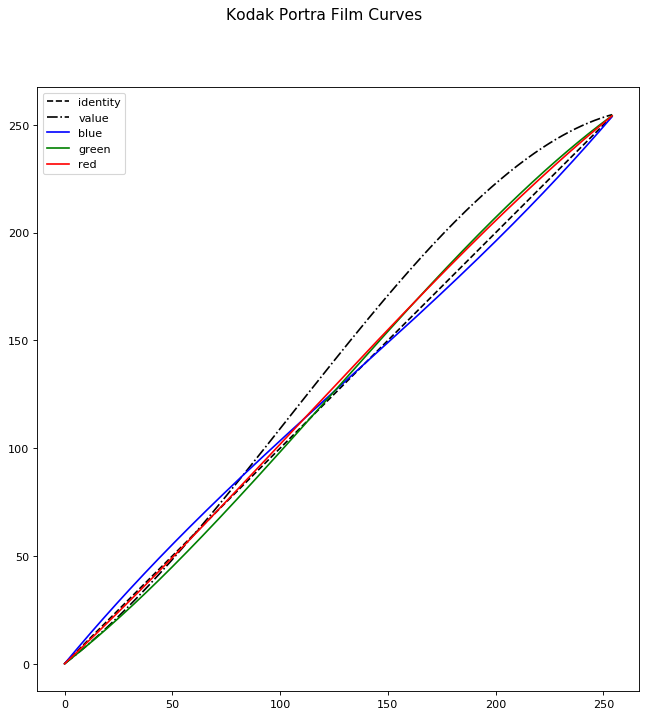

In [13]:
portraPointsV = [(0,0),(23,20),(205,227),(255,255)]
portraPointsB = [(0,0),(41,46),(231,228),(255,255)]
portraPointsG = [(0,0),(52,47),(189,196),(255,255)]
portraPointsR = [(0,0),(69,69),(213,218),(255,255)]

Vcurve = createCurve(portraPointsV)
Bcurve = createCurve(portraPointsB)
Gcurve = createCurve(portraPointsG)
Rcurve = createCurve(portraPointsR)

x = np.arange(0,255,1)
V = Vcurve(x); B = Bcurve(x); G = Gcurve(x); R = Rcurve(x)

fig = plt.figure(figsize=(14,10),dpi=80)
fig.suptitle('Kodak Portra Film Curves',fontsize=14)
ax  = fig.add_subplot(111)
ax.set_aspect('equal')
ax.plot(x,x,'k--',x,V,'k-.',x,B,'b-',x,G,'g-',x,R,'r-')
xx = ax.legend(['identity','value','blue','green','red'])

In [14]:
class KodakPortraFilter(BGRCurveFilter):
    def __init__(self,dtype = np.uint8):
        BGRCurveFilter.__init__(self,
                               vPoints = portraPointsV,
                               bPoints = portraPointsB,
                               gPoints = portraPointsG,
                               rPoints = portraPointsR,
                               dtype = dtype)

---
Fuji Provia film.  This film is described in [ref 1] as:

> Provia has strong contrast and is slightly cool (blue) throughout most tones.
> Sky, water, and shade are enhanced more than sun.

Note that this film does not include a value curve, so the overall intensity is not varied.

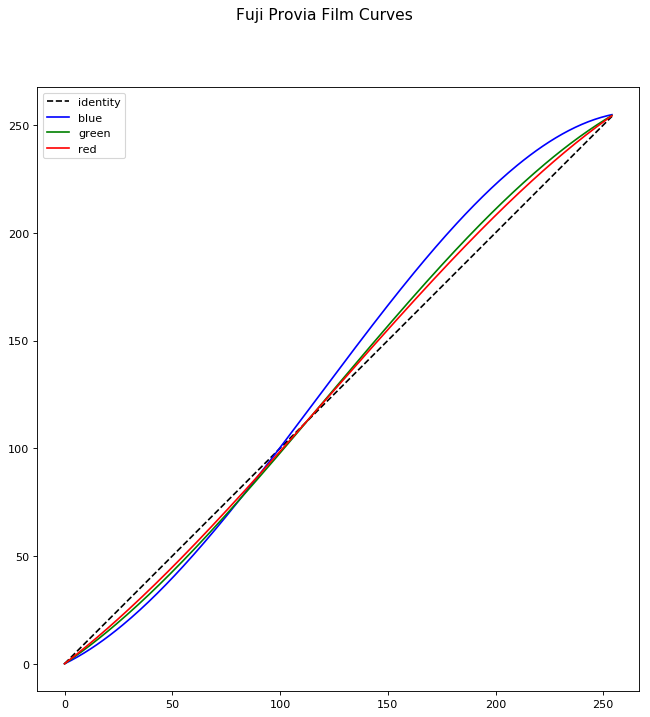

In [15]:
proviaPointsB = [(0,0),(35,25),(205,227),(255,255)]
proviaPointsG = [(0,0),(27,21),(196,207),(255,255)]
proviaPointsR = [(0,0),(59,54),(202,210),(255,255)]

Bcurve = createCurve(proviaPointsB)
Gcurve = createCurve(proviaPointsG)
Rcurve = createCurve(proviaPointsR)

x = np.arange(0,255,1)
B = Bcurve(x); G = Gcurve(x); R = Rcurve(x)

fig = plt.figure(figsize=(14,10),dpi=80)
fig.suptitle('Fuji Provia Film Curves',fontsize=14)
ax  = fig.add_subplot(111)
ax.set_aspect('equal')
ax.plot(x,x,'k--',x,B,'b-',x,G,'g-',x,R,'r-')
ax.legend(['identity','blue','green','red'])

In [16]:
class FujiProviaFilter(BGRCurveFilter):
    def __init__(self,dtype = np.uint8):
        BGRCurveFilter.__init__(self,
                               bPoints = proviaPointsB,
                               gPoints = proviaPointsG,
                               rPoints = proviaPointsR,
                               dtype = dtype)

---
Fuji Velvia film.  This film is described in [ref 1] as:

> Velvia has deep shadows and vivid colors. It can often produce azure skies in
> daytime and crimson clouds at sunset. The effect is difficult to emulate...

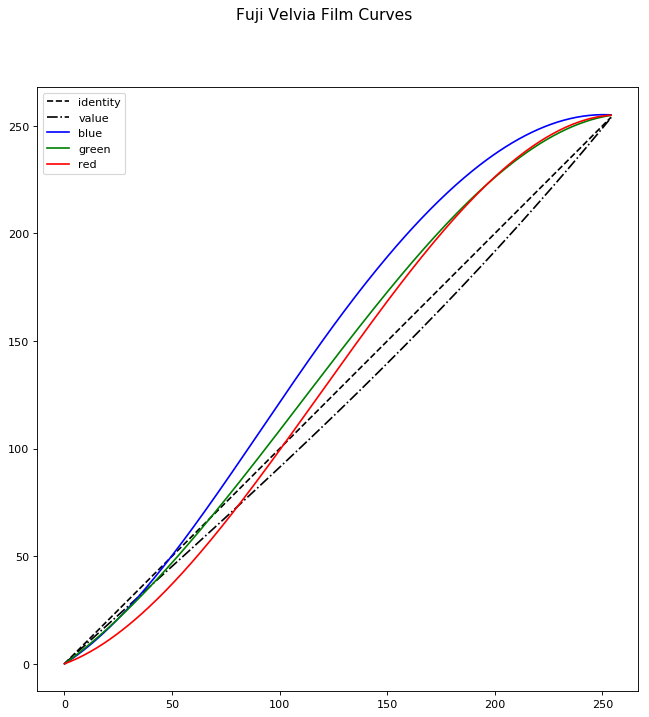

In [17]:
velviaPointsV = [(0,0),(128,118),(221,215),(255,255)]
velviaPointsB = [(0,0),( 25, 21),(122,153),(165,206),(255,255)]
velviaPointsG = [(0,0),( 25, 21),( 95,102),(181,208),(255,255)]
velviaPointsR = [(0,0),( 41, 28),(183,209),(255,255)]

Vcurve = createCurve(velviaPointsV)
Bcurve = createCurve(velviaPointsB)
Gcurve = createCurve(velviaPointsG)
Rcurve = createCurve(velviaPointsR)

x = np.arange(0,255,1)
V = Vcurve(x); B = Bcurve(x); G = Gcurve(x); R = Rcurve(x)

fig = plt.figure(figsize=(14,10),dpi=80)
fig.suptitle('Fuji Velvia Film Curves',fontsize=14)
ax  = fig.add_subplot(111)
ax.set_aspect('equal')
ax.plot(x,x,'k--',x,V,'k-.',x,B,'b-',x,G,'g-',x,R,'r-')
xx = ax.legend(['identity','value','blue','green','red'])

In [18]:
class FujiVelviaFilter(BGRCurveFilter):
    def __init__(self,dtype = np.uint8):
        BGRCurveFilter.__init__(self,
                               vPoints = velviaPointsV,
                               bPoints = velviaPointsB,
                               gPoints = velviaPointsG,
                               rPoints = velviaPointsR,
                               dtype = dtype)

---
Film cross processing.  This effect is described in [ref 1] as:

> Cross-processing produces a strong, blue or greenish-blue tint in shadows and a strong,
> yellow or greenish-yellow in highlights. Black and white are not necessarily preserved.
> Also, contrast is very high. Cross-processed photos take on a sickly appearance. People
> look jaundiced, while inanimate objects look stained.

Note that film cross processing also does not include a value curve, so the overall intensity is not varied.

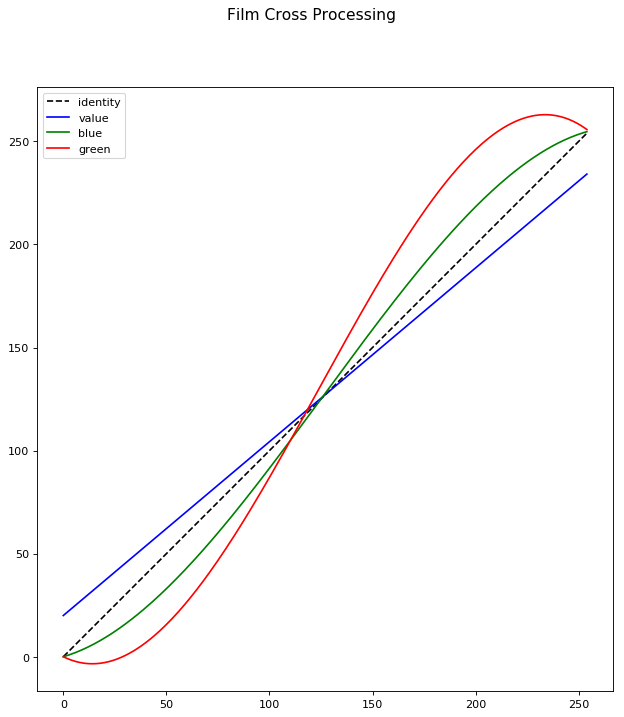

In [19]:
crossPointsB = [(0,20),(255,235)]
crossPointsG = [(0,0),(56,39),(208,226),(255,255)]
crossPointsR = [(0,0),(56,22),(211,255),(255,255)]

Bcurve = createCurve(crossPointsB)
Gcurve = createCurve(crossPointsG)
Rcurve = createCurve(crossPointsR)

x = np.arange(0,255,1)
B = Bcurve(x); G = Gcurve(x); R = Rcurve(x)

fig = plt.figure(figsize=(14,10),dpi=80)
fig.suptitle('Film Cross Processing',fontsize=14)
ax  = fig.add_subplot(111)
ax.set_aspect('equal')
ax.plot(x,x,'k--',x,B,'b-',x,G,'g-',x,R,'r-')
xx = ax.legend(['identity','value','blue','green','red'])

In [20]:
class CrossProcessingFilter(BGRCurveFilter):
    def __init__(self,dtype = np.uint8):
        BGRCurveFilter.__init__(self,
                               bPoints = crossPointsB,
                               gPoints = crossPointsG,
                               rPoints = crossPointsR,
                               dtype = dtype)

### Filtered Images

So now we can construct a filter for each of the film types and compare images before and after filtering.

In [21]:
kodakFilter  = KodakPortraFilter()
proviaFilter = FujiProviaFilter()
velviaFilter = FujiVelviaFilter()
crossFilter  = CrossProcessingFilter()

In [22]:
bgr_image = cv2.imread('portrait.jpg')
rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)

In [23]:
kodak  = bgr_image.copy()
provia = bgr_image.copy()
velvia = bgr_image.copy()
cross  = bgr_image.copy()

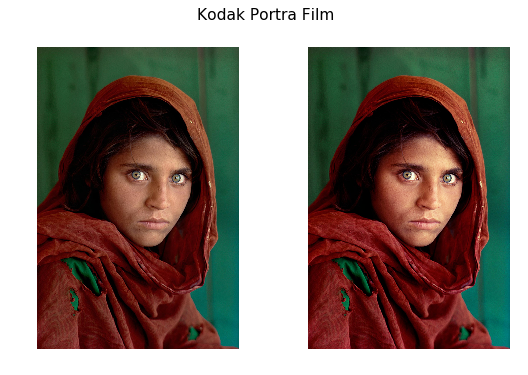

In [24]:
kodakFilter.apply(kodak,kodak); kodak = cv2.cvtColor(kodak, cv2.COLOR_BGR2RGB)
fig,ax = plt.subplots(1,2)
fig.set_size_inches(8.0,5.0); fig.set_dpi(80)
fig.suptitle('Kodak Portra Film',fontsize=14)

ax[0].set_axis_off();ax[1].set_axis_off()
ax[0].imshow(rgb_image); ax[1].imshow(kodak)

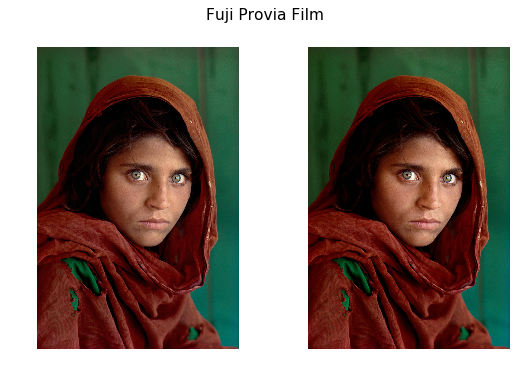

In [25]:
proviaFilter.apply(provia,provia); provia = cv2.cvtColor(provia, cv2.COLOR_BGR2RGB)
fig,ax = plt.subplots(1,2)
fig.set_size_inches(8.0,5.0); fig.set_dpi(80)
fig.suptitle('Fuji Provia Film',fontsize=14)

ax[0].set_axis_off();ax[1].set_axis_off()
ax[0].imshow(rgb_image); ax[1].imshow(provia)

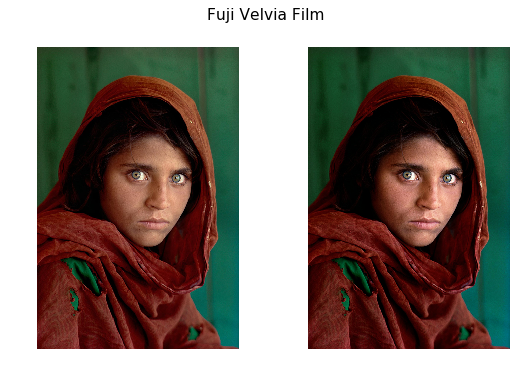

In [26]:
velviaFilter.apply(velvia,velvia); velvia = cv2.cvtColor(velvia, cv2.COLOR_BGR2RGB)
fig,ax = plt.subplots(1,2)
fig.set_size_inches(8.0,5.0); fig.set_dpi(80)
fig.suptitle('Fuji Velvia Film',fontsize=14)

ax[0].set_axis_off();ax[1].set_axis_off()
ax[0].imshow(rgb_image); ax[1].imshow(velvia)

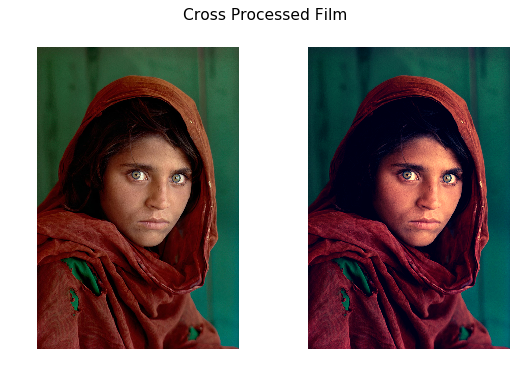

In [27]:
crossFilter.apply(cross,cross); cross = cv2.cvtColor(cross, cv2.COLOR_BGR2RGB)
fig,ax = plt.subplots(1,2)
fig.set_size_inches(8.0,5.0); fig.set_dpi(80)
fig.suptitle('Cross Processed Film',fontsize=14)

ax[0].set_axis_off();ax[1].set_axis_off()
ax[0].imshow(rgb_image); ax[1].imshow(cross)

In [28]:
bgr_image = cv2.imread('students.jpg')
rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)

In [29]:
kodak  = bgr_image.copy()
provia = bgr_image.copy()
velvia = bgr_image.copy()
cross  = bgr_image.copy()

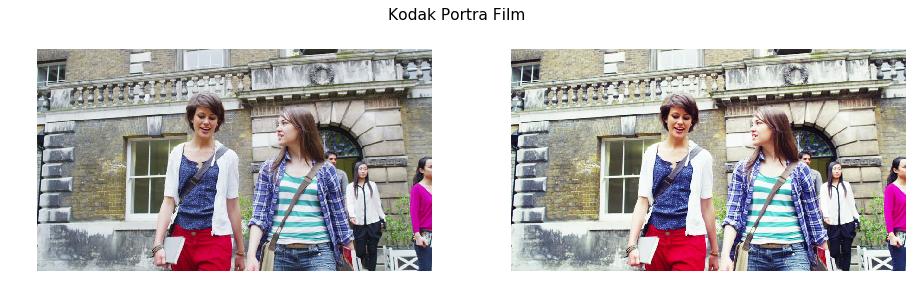

In [30]:
kodakFilter.apply(kodak,kodak); kodak = cv2.cvtColor(kodak, cv2.COLOR_BGR2RGB)
fig,ax = plt.subplots(1,2)
fig.set_size_inches(14,4); fig.set_dpi(80)
fig.suptitle('Kodak Portra Film',fontsize=14)

ax[0].set_axis_off();ax[1].set_axis_off()
ax[0].imshow(rgb_image); ax[1].imshow(kodak)

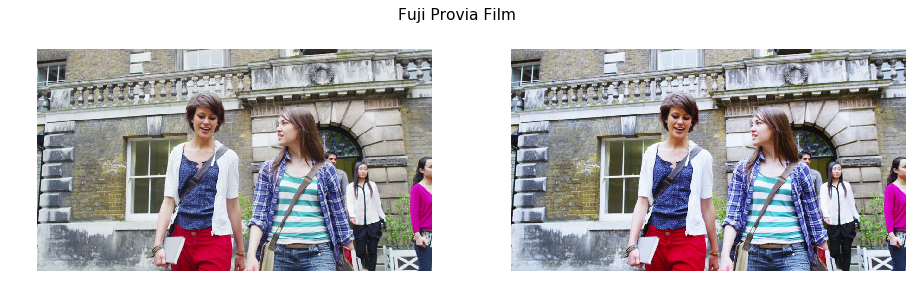

In [31]:
proviaFilter.apply(provia,provia); provia = cv2.cvtColor(provia, cv2.COLOR_BGR2RGB)
fig,ax = plt.subplots(1,2)
fig.set_size_inches(14,4); fig.set_dpi(80)
fig.suptitle('Fuji Provia Film',fontsize=14)

ax[0].set_axis_off();ax[1].set_axis_off()
ax[0].imshow(rgb_image); ax[1].imshow(provia)

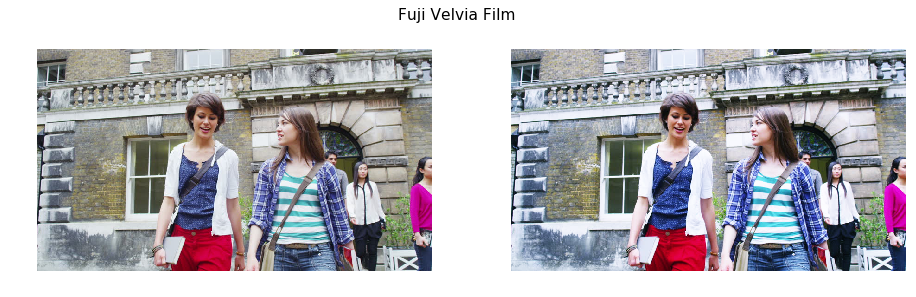

In [32]:
velviaFilter.apply(velvia,velvia); velvia = cv2.cvtColor(velvia, cv2.COLOR_BGR2RGB)
fig,ax = plt.subplots(1,2)
fig.set_size_inches(14,4); fig.set_dpi(80)
fig.suptitle('Fuji Velvia Film',fontsize=14)

ax[0].set_axis_off();ax[1].set_axis_off()
ax[0].imshow(rgb_image); ax[1].imshow(velvia)

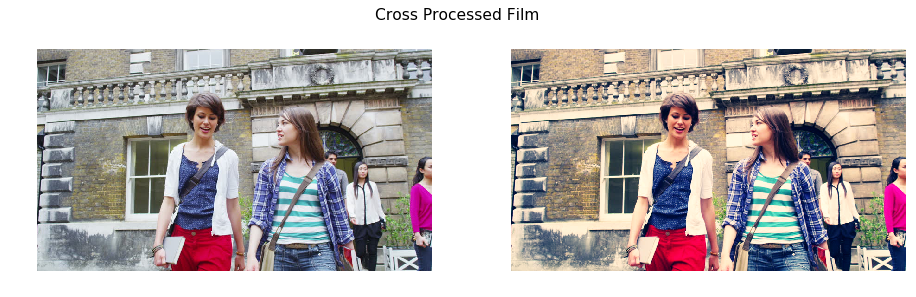

In [33]:
crossFilter.apply(cross,cross); cross = cv2.cvtColor(cross, cv2.COLOR_BGR2RGB)
fig,ax = plt.subplots(1,2)
fig.set_size_inches(14,4); fig.set_dpi(80)
fig.suptitle('Cross Processed Film',fontsize=14)

ax[0].set_axis_off();ax[1].set_axis_off()
ax[0].imshow(rgb_image); ax[1].imshow(cross)